# Segmenteringsanalyse
En case til jobsamtale 
Af Emilie Wedenborg

Opgave: Hvad er de vigtigste parametre for at forudse om en bruger er konverteret eller ej?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataImportXlsx import dataImportXlsx

from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
#import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [2]:
Gendercolors = ["#CAE1FF", "#ffb4cc"]

### Import af data

In [3]:
data = dataImportXlsx("Data.xlsx","Ark1")
data.set_index("customer_id", inplace = True)
# change datatypes: 
data['age'] = pd.to_numeric(data['age'])
data['related_customers'] = pd.to_numeric(data['related_customers'])
data['family_size'] = pd.to_numeric(data['family_size'])
# Age has to be a valid number: 
# I don't know anything about the data, so it does not make sense to enforce an age limit
data = data[data['age']>0]
n,m = data.shape
print("The number of rows is:", n)
print("The number of cols is:", m)
data.head()


The number of rows is: 714
The number of cols is: 9


,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
customer_id,,,,,,,,,
15001,0,13,male,22.0,1,0,14.5,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
15003,1,13,female,26.0,0,0,15.85,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15004,1,11,female,35.0,1,0,106.2,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
15005,0,13,male,35.0,0,0,16.1,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


### Inspektion af data
Her kigges der på de forskellige variable for at se om, der er noget, der kan renses yderligere eller andre opmærksomhedspunkter, der kan påvirke modelvalget. 

Først undersøges det om der er stor ubalance i prædiktionsvariablen: 

In [4]:
print("Percentage of converted in data is: {:.2f}".format(data.converted.value_counts()[1]/n*100),"%")

Percentage of converted in data is: 40.62 %


Det ser ikke ud til at være et stort problem, da de fleste modeller kan håndtere lidt ubalance. 

#### Alder:
Alderen for hvert køn vises i et histogram. Overtal af yngre med få gamle. 

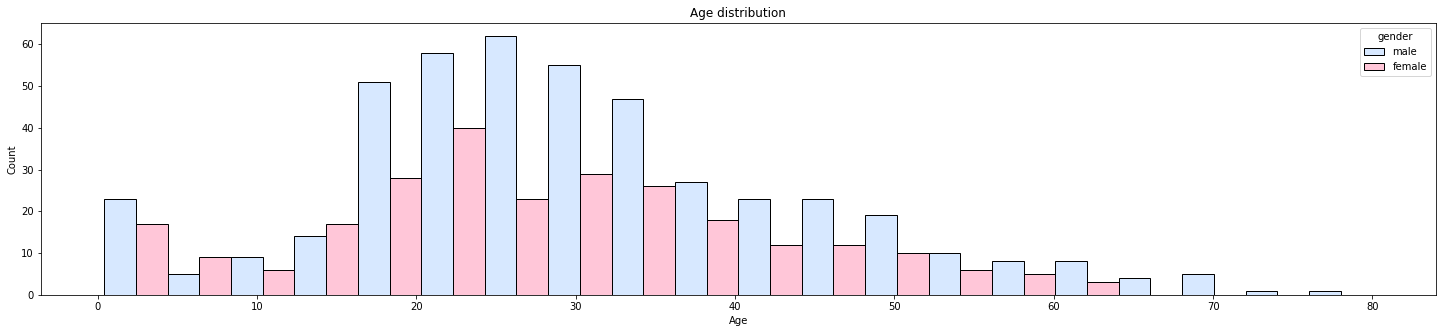

In [5]:
plt.figure(figsize=(25,5))
sns.histplot(data, x = "age",hue="gender",multiple='dodge',palette=sns.color_palette(Gendercolors))
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

#### Credit account ID's 
Fra opgave er der givet en hash, der betyder NaN:

In [6]:
Nan = "9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0"
data[data["credit_account_id"] ==Nan].head()

,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
customer_id,,,,,,,,,
15001,0,13,male,22.0,1,0,14.5,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15003,1,13,female,26.0,0,0,15.85,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15005,0,13,male,35.0,0,0,16.1,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15008,0,13,male,2.0,3,1,42.15,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
15009,1,13,female,27.0,0,2,22.2666,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


In [7]:
data[data["credit_account_id"] ==Nan].shape

(529, 9)

Langt de fleste har ikke et credit_account_id, og det er heller ikke unikt? Ville give mening, hvis man inden for en familie kunne dele credit account.

In [8]:
data.credit_account_id.value_counts()

9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0    529
f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479feee41224ef86f7174a      4
cec0a7de7f8d6fc385250a76e38555a1f45fd5aaeb1a2ba3dbdf90a049bb0681      4
780d558be6960a54064f888577409d1c92eb7c3d6c65e6bf4f286a3e26dde543      4
8e2de3335023201ffa4d803767bdf12790c58f4f241554c544bde8bf7b8455a4      3
                                                                   ... 
6ab09b834603a8cb76aadd2417233a4b05e9328f21fdde6e1b95340e0eb38409      1
3241a3009222adcfd375825dcd95bd9c5c17a5e37e76cc04c121faa2f2fe569e      1
fb44388faf2a4c02c6e64ada837ee39b2af11e805c12a9f25390281d3b65c87c      1
85819be79f31aeb746251daac765c03d826025b366df8e777edf28812d948f72      1
a2b612f45840d6f27b1a73ddae7f50e0bd9c4935903de602fdbc2da6d62e06a8      1
Name: credit_account_id, Length: 135, dtype: int64

Nu kigges der nærmere på et credit_account_id, for at se om der er noget, der tyder på at de er i familie?

In [9]:
data[data['credit_account_id']=='f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479feee41224ef86f7174a']

,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
customer_id,,,,,,,,,
15028,0,11,male,19.0,3,2,526.0,f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479f...,Helsinki
15089,1,11,female,23.0,3,2,526.0,f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479f...,Helsinki
15342,1,11,female,24.0,3,2,526.0,f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479f...,Helsinki
15439,0,11,male,64.0,1,4,526.0,f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479f...,Helsinki


Den ældre mand har en family size på 4, men det er der ikke nogen af de andre, der har... De 3 yngre har 3 ´related_customers´. Kunne måske være noget med hvordan man angiver det, men det ville kræve mere analyse at sige noget mere om det og selv hvis man kan gælder det kun for en lille del af dataen og ville derfor ikke rigtig kunne bruges.

For nu laves der en binær variabel om man har en account eller ej. 

In [10]:
data["hasAccount"]= data['credit_account_id'].map(lambda x: x ==Nan)

In [11]:
data["hasAccount"].value_counts()

True     529
False    185
Name: hasAccount, dtype: int64

Den gamle kolonne droppes, da den er stærkt korreleret med med den nye. 

In [12]:
data.drop("credit_account_id", axis = 1, inplace = True)

#### Køn
Køn bliver ændret til binær: 

In [13]:
data['gender'] = (data['gender'] == 'male').astype(int) ## male = 1, female = 0 

#### Branch
Nu inspiseres branch:

In [14]:
data.branch.value_counts()

Helsinki    554
Tampere     130
Turku        28
              2
Name: branch, dtype: int64

In [15]:
# Remove empty variables: 
data = data[data['branch']!='']

In [16]:
# One hot encode string variable: 
data = pd.get_dummies(data, prefix = "branch", columns=["branch"])

#### Related customers og family size:

Det er nærliggende at tro, at de to variable måske er correleret. Dette undersøges derfor nærmere: 

In [17]:
data.related_customers.value_counts()

0    469
1    183
2     25
4     18
3     12
5      5
Name: related_customers, dtype: int64

In [18]:
data.family_size.value_counts()

0    519
1    110
2     68
5      5
3      5
4      4
6      1
Name: family_size, dtype: int64

In [19]:
print('related_customers: mean=%.3f stdv=%.3f' % (np.mean(data.related_customers), np.std(data.related_customers)))
print('family_size: mean=%.3f stdv=%.3f' % (np.mean(data.family_size), np.std(data.family_size)))

covariance = np.corrcoef(data.related_customers, data.family_size)
print('Correlation between related_customers and family_size: %.3f' % covariance[0,1])


related_customers: mean=0.514 stdv=0.930
family_size: mean=0.433 stdv=0.854
Correlation between related_customers and family_size: 0.383


De to variable er lidt korrelerede, men ikke noget, der burde have indflydelse på analysen... Der bliver derfor ikke gjort noget mere ud af de to variable. 

Til slut undersøges korrelationen, for at se om hvordan de forskellige variable er korrelerede med hinanden: 

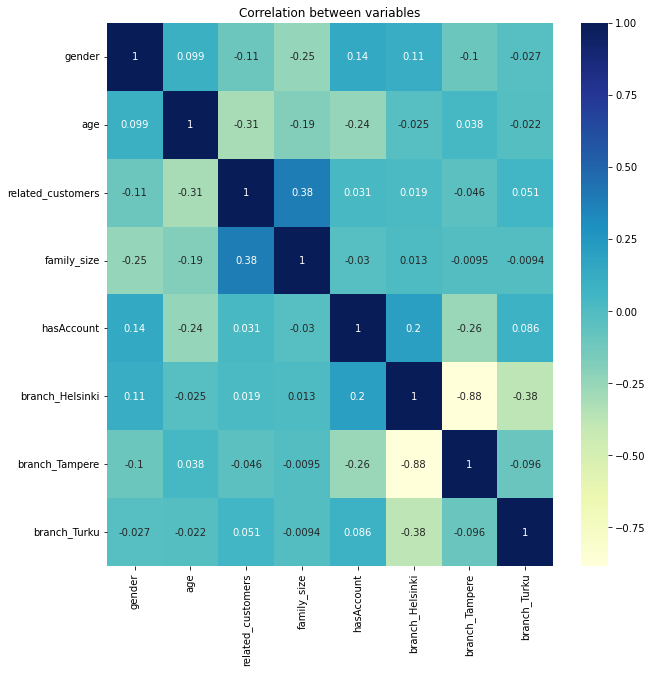

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation between variables")
plt.show()

## Nu til analysedelen: 
Dataen splittes:

In [21]:
y = data.converted
X = data.drop("converted", axis = 1)

Modellen opstilles. Her anvendes en random forrest classifier, da denne er rimelig robust og kan håndtere en lille smule class imbalance. 

Der laves en 5-fold CV, for at modvirke overfitting. Hyperparametrene testes i en gridsearch for at finde de optimale. 

In [22]:
K = 5

kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=112)

y_true =[]
y_pred = []

n_estimators = np.arange(50,200,4)
max_depth = range(1,5)

accuracies = np.zeros(K)
chosen_parameters = np.zeros((2,K))

for i, (train_index, test_index) in enumerate(kf.split(X,y)):

    X_train, X_test = X.iloc[train_index,], X.iloc[test_index,]
    y_train, y_test = y[train_index], y[test_index]
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # define classifier model
    clf = RandomForestClassifier(bootstrap=True, oob_score=True, criterion='gini', random_state=0, warm_start=True)
    
    # define parameters for grid search 
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

    # perform grid search
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)

    accuracies[i] = grid.score(X_test, y_test)

    y_true += list(y_test)
    y_pred += list(grid.predict(X_test))

    chosen_parameters[0,i] = grid.best_params_['max_depth']
    chosen_parameters[1,i] = grid.best_params_['n_estimators']

    print(('CV split: {}, Acc: {}').format(i, accuracies[i]))


Fitting 5 folds for each of 152 candidates, totalling 760 fits
CV split: 0, Acc: 0.8181818181818182
Fitting 5 folds for each of 152 candidates, totalling 760 fits
CV split: 1, Acc: 0.7902097902097902
Fitting 5 folds for each of 152 candidates, totalling 760 fits
CV split: 2, Acc: 0.7746478873239436
Fitting 5 folds for each of 152 candidates, totalling 760 fits
CV split: 3, Acc: 0.795774647887324
Fitting 5 folds for each of 152 candidates, totalling 760 fits
CV split: 4, Acc: 0.8450704225352113


In [23]:
max_accuracy_idx = np.argmax(accuracies)
best_max_depth = int(chosen_parameters[0][max_accuracy_idx])
best_n_estimators = int(chosen_parameters[1][max_accuracy_idx])

print('Best parameters. (1) max_depth = {}, (2) n_estimators = {}'.format(best_max_depth, best_n_estimators))

Best parameters. (1) max_depth = 4, (2) n_estimators = 50


In [24]:
indeces = np.arange(X.shape[0])

model_assessment_accuracies = np.zeros(K)

targets = []
predicitons = []

for i in range(K):

  # select indecies for bootstraping
  boot_indeces = resample(indeces, replace=True, n_samples=X.shape[0], random_state=1)

  # out of bag indeces
  oob_indeces = [i for i in indeces if i not in boot_indeces]

  X_train, y_train = X.iloc[boot_indeces], y.iloc[boot_indeces]
  X_test, y_test = X.iloc[oob_indeces], y.iloc[oob_indeces]


  # define classifier model using best learned parameters
  clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, oob_score=True, criterion='gini', random_state=0, class_weight='balanced')
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  model_assessment_accuracies[i] = accuracy_score(y_test, y_pred)

  targets += list(y_test)
  predicitons += list(y_pred)

print('Expected Accuracy {:.2f} '.format(np.mean(model_assessment_accuracies)))

Expected Accuracy 0.78 


Den indbyggede funktion feature importance bruges til at finde ud af hvilke features, der er mest relevante for at prædiktere: 

Feature: 0, Score: 0.14111
Feature: 1, Score: 0.40396
Feature: 2, Score: 0.11075
Feature: 3, Score: 0.04794
Feature: 4, Score: 0.02088
Feature: 5, Score: 0.13008
Feature: 6, Score: 0.10782
Feature: 7, Score: 0.00692
Feature: 8, Score: 0.01944
Feature: 9, Score: 0.01110


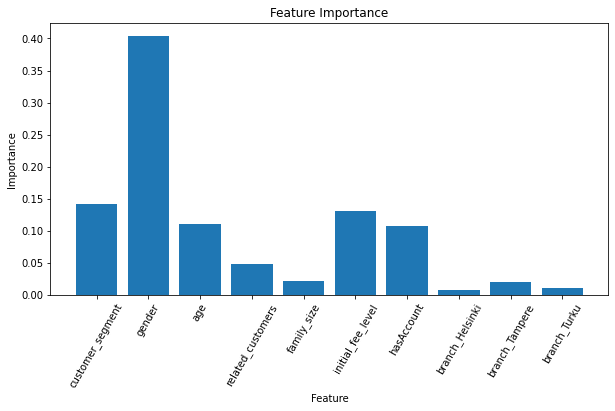

In [25]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(10,5))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance')
plt.xticks(range(len(importance)), X.columns,rotation=60)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

Da feature importance er følsom over for variable med high cardinality (many unique values) testes det også med permutation importance: 

In [26]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)

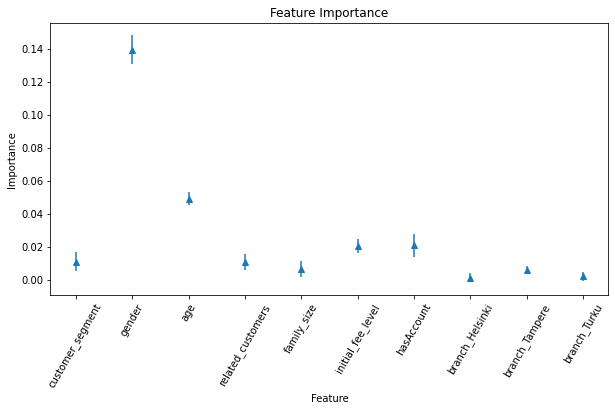

In [27]:
# plot feature importance
plt.figure(figsize=(10,5))
plt.errorbar(range(len(result.importances_std)), result.importances_mean, result.importances_std, linestyle='None', marker='^')
plt.title('Feature Importance')
plt.xticks(range(len(importance)), X.columns,rotation=60)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

Det er helt tydeligt køn, der har en største betydning. For begge metoder har age også ret stor betydning. Der er uenighed om customer_segment, så det skal nok lige undersøges nærmere. Både initial fee og om de har en credit account eller ej, har også lidt betydning. 

#### Konklusion

De mest betydende parametre for analysen er:
-  Gender
- Age

og til en mindre grad

- Initial fee
- hasAccount
- customer_segment